In [1]:
# based on
# scaled up to full MNIST dataset
# https://github.com/SadmanSakib93/Federated-Learning-Keras/blob/main/Fed%20Learning%20-%20FL.ipynb

In [2]:
root_path=''

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Convolution2D, Conv1D
from tensorflow.keras.layers import MaxPooling2D, MaxPooling1D
from keras import backend as K
from keras import backend
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import time
import os
import psutil
import csv
from itertools import repeat
from PIL import Image
from numpy import asarray

2023-02-05 11:36:56.829128: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-05 11:36:56.829150: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
from keras.datasets import mnist
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()

xTrain = xTrain.reshape(60000, 784)
xTest = xTest.reshape(10000, 784)
xTrain = xTrain.astype('float32')
x_test = xTest.astype('float32')
xTrain /= 255
x_test /= 255
print(xTrain.shape[0], 'train samples')
print(xTest.shape[0], 'test samples')

# convert class vectors to binary class matrices
yTrain = to_categorical(yTrain, 10)
yTest = to_categorical(yTest, 10)
yTrain.shape

60000 train samples
10000 test samples


(60000, 10)

In [5]:
# FOR TEST SPLIT
xServer, xClients, yServer, yClients = train_test_split(xTrain, yTrain, test_size=0.80,random_state=523) 

In [6]:
def createDeepModel():
   model = Sequential()
   model.add(Dense(64, activation='relu', input_shape=(784,)))
   model.add(Dense(128, activation='relu'))
   model.add(Dense(64, activation='relu'))
   model.add(Dense(10, activation='softmax'))
   model.summary()
#  model.add(Flatten())
   model.compile(loss='categorical_crossentropy',optimizer=RMSprop(),
              metrics=['accuracy'])
   return model

def predictTestData(yPredict, yTest):
    #Converting predictions to label
    print("yPredict",len(yPredict))
    pred = list()
    for i in range(len(yPredict)):
        pred.append(np.argmax(yPredict[i]))
    #Converting one hot encoded test label to label
    test = list()
    for i in range(len(yTest)):
        test.append(np.argmax(yTest[i]))
    return my_metrics(test, pred)

def sumOfWeights(weights):
    return sum(map(sum, weights))

def getWeights(model):
    allLayersWeights=deepModel.get_weights()
    return allLayersWeights

def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    recall=recall_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, recall, f1Score

In [7]:
# Initially train central deep model
deepModel=createDeepModel()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 67,466
Trainable params: 67,466
Non-trainable params: 0
_________________________________________________________________


2023-02-05 11:36:59.375085: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 11:36:59.376639: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-05 11:36:59.377047: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-02-05 11:36:59.377348: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-02-05 11:36:59.383181: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [8]:
# Parameters and initialization variables
verbose, epochs, batch_size = 1, 20, 64
numOfIterations=50
numOfClients  = 10 # 10, 15, 20, 25, 30, 35, 40, 45, 50
modelLocation = "./Models/ANN_Sync_users_"+str(numOfClients)+str(numOfIterations)+"_FL_Model.h5"
accList, precList, recallList, f1List = [], [], [], []

In [9]:
deepModelAggWeights=[]
firstClientFlag=True

def updateServerModel(clientModel, clientModelWeight):
    global firstClientFlag
    for ind in range(len(clientModelWeight)):
        if(firstClientFlag==True):
            deepModelAggWeights.append(clientModelWeight[ind])            
        else:
            deepModelAggWeights[ind]=(deepModelAggWeights[ind]+clientModelWeight[ind])

def updateClientsModels():
    global clientsModelList
    global deepModel
    clientsModelList.clear()
    for clientID in range(numOfClients):
        m = keras.models.clone_model(deepModel)
        m.set_weights(deepModel.get_weights())
        clientsModelList.append(m)
    


In [10]:
history = deepModel.fit(xTrain, yTrain,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(xTest, yTest))

Epoch 1/20
938/938 [==============================] - 3s 2ms/step - loss: 0.2912 - accuracy: 0.9134 - val_loss: 25.3439 - val_accuracy: 0.9498
Epoch 2/20
938/938 [==============================] - 2s 2ms/step - loss: 0.1291 - accuracy: 0.9609 - val_loss: 23.0899 - val_accuracy: 0.9606
Epoch 3/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0922 - accuracy: 0.9718 - val_loss: 17.5197 - val_accuracy: 0.9707
Epoch 4/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0748 - accuracy: 0.9778 - val_loss: 20.3301 - val_accuracy: 0.9706
Epoch 5/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0627 - accuracy: 0.9810 - val_loss: 22.2717 - val_accuracy: 0.9652
Epoch 6/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0531 - accuracy: 0.9833 - val_loss: 20.1096 - val_accuracy: 0.9735
Epoch 7/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0458 - accuracy: 0.9859 - val_loss: 25.3946 - val_accuracy: 0.9690

In [11]:
# 1. Train central model initially -----
def trainInServer():
    deepModel.fit(xServer, yServer, epochs=epochs, batch_size=batch_size, verbose=verbose)
#   deepModel.fit(xTrain, yTrain, epochs=epochs, batch_size=batch_size, verbose=verbose)# test with all dataset
    deepModel.save(modelLocation)
    
trainInServer()

Epoch 1/20
188/188 [==============================] - 0s 2ms/step - loss: 0.0120 - accuracy: 0.9970
Epoch 2/20
188/188 [==============================] - 0s 2ms/step - loss: 0.0058 - accuracy: 0.9984
Epoch 3/20
188/188 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 0.9992
Epoch 4/20
188/188 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 0.9992
Epoch 5/20
188/188 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9996
Epoch 6/20
188/188 [==============================] - 0s 2ms/step - loss: 0.0044 - accuracy: 0.9988
Epoch 7/20
188/188 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 0.9992
Epoch 8/20
188/188 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9997
Epoch 9/20
188/188 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9995
Epoch 10/20
188/188 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9993

In [21]:
# ------- 2. Separate clients data into lists ----------
xClientsList=[]
yClientsList=[]
clientsModelList=[]
clientDataInterval=len(xClients)//numOfClients
lastLowerBound=0

for clientID in range(numOfClients):
    xClientsList.append(xClients[lastLowerBound : lastLowerBound+clientDataInterval])
    yClientsList.append(yClients[lastLowerBound : lastLowerBound+clientDataInterval])
    model=load_model(modelLocation)
    clientsModelList.append(model)
    lastLowerBound+=clientDataInterval
yClientsList[1].shape

(4800, 10)

In [53]:
print (b)

[0 1 2 3 4 5 6 7 8 9]


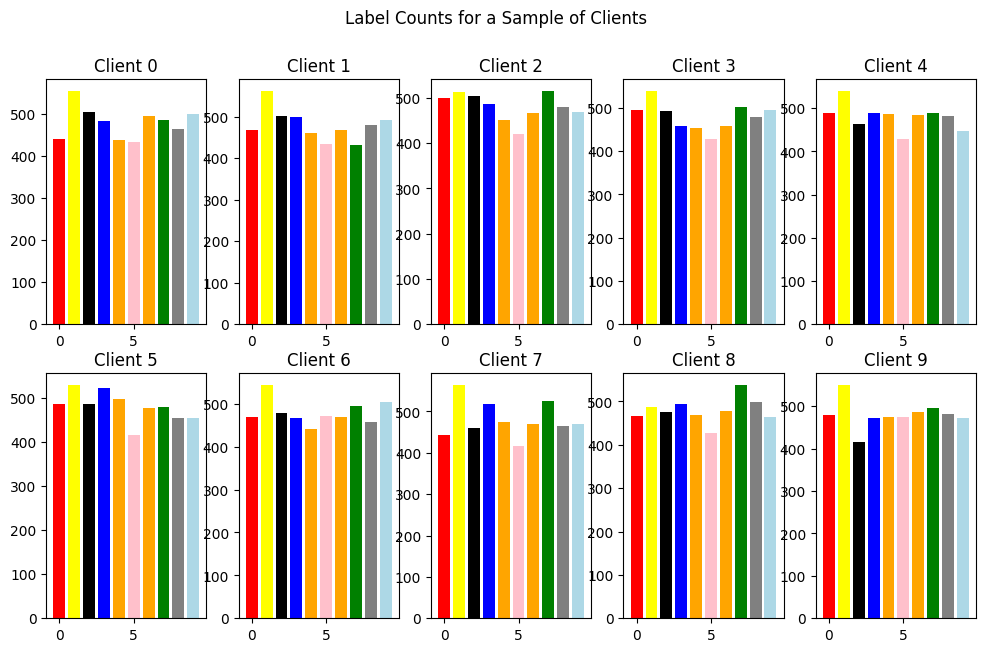

In [66]:
# Number of examples per layer for a sample of clients
import matplotlib.colors as mcolors

c = ['red', 'yellow', 'black', 'blue', 'orange', 'pink', 'orange', 'green', 'grey', 'lightblue']


f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')
b = np.arange(0, 10, 1)
for i in range(numOfClients):
    client_dataset = yClientsList[i]
    bin = client_dataset[0]
    for k in range(1,len(client_dataset)):
       bin = bin + client_dataset[k]
    np.squeeze(bin).shape
    plt.subplot(int(numOfClients/5), 5, i+1)
    plt.title('Client {}'.format(i))
    plt.bar(b,bin[b], color = c)
        
       


In [13]:
# ------- 3. Update clients' model with intial server's deep-model ----------

for clientID in range(numOfClients):
    clientsModelList[clientID].fit(xClientsList[clientID], yClientsList[clientID], epochs=epochs, batch_size=batch_size, verbose=verbose)
        
start_time = time.time()
process = psutil.Process(os.getpid())
for iterationNo in range(1,numOfIterations+1):
    print("Iteration",iterationNo)
    for clientID in range(numOfClients):
        print("clientID",clientID)
        clientsModelList[clientID].compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
        clientsModelList[clientID].fit(xClientsList[clientID], yClientsList[clientID], epochs=epochs, batch_size=batch_size, verbose=verbose)
        clientWeight=clientsModelList[clientID].get_weights()
        # Find sum of all client's model
        updateServerModel(clientsModelList[clientID], clientWeight)
        firstClientFlag=False
    #Avarage all clients model
    for ind in range(len(deepModelAggWeights)):
        deepModelAggWeights[ind]/=numOfClients

    dw_last=deepModel.get_weights()

    for ind in range(len(deepModelAggWeights)): 
        dw_last[ind]=deepModelAggWeights[ind]
     
    #Update server's model
    deepModel.set_weights(dw_last) 
    print("Server's model updated")
    print("Saving model . . .")
    deepModel.save(modelLocation)
    # Servers model is updated, now it can be used again by the clients
    updateClientsModels()
    firstClientFlag=True
    deepModelAggWeights.clear()

    yPredict = deepModel.predict(xTest)
    acc, prec, recall, f1Score= predictTestData(yPredict, yTest)
    accList.append(acc)
    precList.append(prec)
    recallList.append(recall)
    f1List.append(f1Score)
    print("Acc:\n", acc)
    print("Prec:\n", prec)
    print("Recall:\n", recall)
    print("F1-Score:\n", f1Score)



Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0781 - accuracy: 0.9877
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0154 - accuracy: 0.9956
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 0.9990
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 0.9985
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 0.9979
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 0.9996
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9998
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 7.4420e-04 - accuracy: 0.9998
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9998
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 1.4493e-04 - accuracy: 1.0000
Epoch 11/20

75/75 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9977
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0109 - accuracy: 0.9973
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2880e-04 - accuracy: 1.0000
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 0.9994
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 0.9990
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 1.5835e-04 - accuracy: 1.0000
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9996
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 5.2055e-04 - accuracy: 0.9998
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 3.4670e-05 - accuracy: 1.0000
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 4.8762e-04 - accuracy: 0.9998
Epoch 12/

75/75 [==============================] - 0s 2ms/step - loss: 0.0102 - accuracy: 0.9971
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 0.9987
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9985
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 9.3159e-04 - accuracy: 0.9998
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9996
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 0.9992
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 4.3584e-05 - accuracy: 1.0000
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 1.8652e-04 - accuracy: 1.0000
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 2.2891e-05 - accuracy: 1.0000
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 6.5561e-06 - accuracy: 1.0000
Epoch 13

75/75 [==============================] - 0s 2ms/step - loss: 2.6613e-15 - accuracy: 1.0000
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 2.6612e-15 - accuracy: 1.0000
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 2.6612e-15 - accuracy: 1.0000
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 2.6612e-15 - accuracy: 1.0000
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 2.6612e-15 - accuracy: 1.0000
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 2.6612e-15 - accuracy: 1.0000
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 2.6611e-15 - accuracy: 1.0000
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 2.6611e-15 - accuracy: 1.0000
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 2.6318e-15 - accuracy: 1.0000
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 2.6318e-15 - accur

Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 5.4619e-18 - accuracy: 1.0000
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 5.4619e-18 - accuracy: 1.0000
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 5.4619e-18 - accuracy: 1.0000
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 5.4619e-18 - accuracy: 1.0000
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 5.4619e-18 - accuracy: 1.0000
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 5.4619e-18 - accuracy: 1.0000
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 5.4619e-18 - accuracy: 1.0000
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 5.4619e-18 - accuracy: 1.0000
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 5.4619e-18 - accuracy: 1.0000
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 5.4619e

75/75 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 0.9867
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 0.9871
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9921
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 0.9902
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9927
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.9902
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 0.9871
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9915
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9933
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9937
Epoch 11/20
75/75 [===========

75/75 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 0.9896
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 0.9887
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9923
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9931
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 7.5838e-04 - accuracy: 0.9954
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 8.6693e-04 - accuracy: 0.9952
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 7.6344e-04 - accuracy: 0.9958
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 9.7686e-04 - accuracy: 0.9946
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9929
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 8.1751e-04 - accuracy: 0.9956
Epoch 12/

75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9921
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 0.9873
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9933
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9927
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.9906
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9910
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.9908
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9919
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 6.5908e-04 - accuracy: 0.9962
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 9.1603e-04 - accuracy: 0.9950
Epoch 13/20
75/75 [=

75/75 [==============================] - 0s 2ms/step - loss: 3.5309e-04 - accuracy: 0.9981
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 3.9253e-04 - accuracy: 0.9975
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 5.9843e-04 - accuracy: 0.9962
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 8.8694e-04 - accuracy: 0.9946
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 1.8533e-04 - accuracy: 0.9992
clientID 2
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9940
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9896
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 7.4419e-04 - accuracy: 0.9958
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9935
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy:

75/75 [==============================] - 0s 2ms/step - loss: 3.8550e-04 - accuracy: 0.9981
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 3.7232e-04 - accuracy: 0.9977
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 3.8508e-04 - accuracy: 0.9979
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 2.8853e-04 - accuracy: 0.9985
clientID 6
Epoch 1/20
75/75 [==============================] - 1s 2ms/step - loss: 8.5136e-04 - accuracy: 0.9948
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9906
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9923
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9946
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 7.9161e-04 - accuracy: 0.9958
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 

75/75 [==============================] - 0s 2ms/step - loss: 9.1806e-04 - accuracy: 0.9948
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 6.8840e-04 - accuracy: 0.9960
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 6.2594e-04 - accuracy: 0.9954
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.98
Precision : 0.9800525812376236
Recall : 0.98
f1Score : 0.9799857139374702
[[ 972    0    2    0    1    0    1    1    3    0]
 [   0 1128    2    0    0    0    3    1    1    0]
 [   3    0 1014    5    2    0    1    4    3    0]
 [   1    0    6  988    0    2    0    4    6    3]
 [   1    0    4    0  966    0    5    1    0    5]
 [   2    0    0    8    1  858   14    1    6    2]
 [   5    2    0    1    2    1  947    0    0    0]
 [   2    4   10    0    0    0    0 1004    4    4]
 [   3    2    5    3    4    3    2    5  944    3]
 [   3    4    0    4   12    0    0    5    2  979]]
Acc:
 0.98
Prec:
 0.9800

75/75 [==============================] - 0s 2ms/step - loss: 7.4114e-04 - accuracy: 0.9960
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 8.8211e-04 - accuracy: 0.9948
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 5.3536e-04 - accuracy: 0.9971
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 9.4034e-04 - accuracy: 0.9944
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 8.6280e-04 - accuracy: 0.9950
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 6.2292e-04 - accuracy: 0.9962
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 7.7253e-04 - accuracy: 0.9960
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 9.3522e-04 - accuracy: 0.9948
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 7.6289e-04 - accuracy: 0.9956
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - acc

75/75 [==============================] - 0s 2ms/step - loss: 5.2526e-04 - accuracy: 0.9971
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 9.5003e-04 - accuracy: 0.9946
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 9.8412e-04 - accuracy: 0.9944
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 3.7138e-04 - accuracy: 0.9981
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 3.2533e-04 - accuracy: 0.9983
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 3.6065e-04 - accuracy: 0.9977
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 2.0029e-04 - accuracy: 0.9990
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 4.8579e-04 - accuracy: 0.9973
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 5.0468e-04 - accuracy: 0.9975
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 5.0025e-04 -

75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9937
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 6.6301e-04 - accuracy: 0.9962
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9925
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9940
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 9.5147e-04 - accuracy: 0.9942
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9937
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 7.0001e-04 - accuracy: 0.9960
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9931
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 6.7189e-04 - accuracy: 0.9965
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 6.5843e-04 - accuracy: 0.9960
Epoch 13

75/75 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 0.9890
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0026 - accuracy: 0.9852
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 0.9898
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9940
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9923
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9931
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 9.8298e-04 - accuracy: 0.9944
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9908
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9933
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9917
Epoch 13/20
75/75 [=====

75/75 [==============================] - 0s 2ms/step - loss: 6.3363e-04 - accuracy: 0.9962
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 8.2683e-04 - accuracy: 0.9954
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 5.1959e-04 - accuracy: 0.9969
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 3.6921e-04 - accuracy: 0.9977
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 7.0016e-04 - accuracy: 0.9958
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 3.2521e-04 - accuracy: 0.9983
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 6.8173e-04 - accuracy: 0.9956
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 8.2935e-04 - accuracy: 0.9950
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 7.4449e-04 - accuracy: 0.9954
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 9.9735e-04 - accu

75/75 [==============================] - 0s 2ms/step - loss: 4.1738e-05 - accuracy: 0.9998
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1726e-05 - accuracy: 0.9998
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1718e-05 - accuracy: 0.9998
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1711e-05 - accuracy: 0.9998
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1706e-05 - accuracy: 0.9998
clientID 3
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 7.3103e-04 - accuracy: 0.9958
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9917
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9923
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9898
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy:

75/75 [==============================] - 0s 2ms/step - loss: 8.5993e-04 - accuracy: 0.9954
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 5.3356e-04 - accuracy: 0.9969
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 5.2393e-04 - accuracy: 0.9971
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 5.9946e-04 - accuracy: 0.9958
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9933
clientID 7
Epoch 1/20
75/75 [==============================] - 1s 2ms/step - loss: 6.3882e-04 - accuracy: 0.9962
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 6.7159e-04 - accuracy: 0.9960
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 5.7714e-04 - accuracy: 0.9965
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 8.2094e-04 - accuracy: 0.9952
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 5.8805e-04

75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9931
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9931
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9933
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 9.3032e-04 - accuracy: 0.9948
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9933
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9944
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9927
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9925
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9929
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 4.9338e-04 - accuracy: 0.9973
Epoch 18/20
75/

75/75 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9915
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 7.1434e-04 - accuracy: 0.9956
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 6.9782e-04 - accuracy: 0.9956
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 9.3994e-04 - accuracy: 0.9946
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9917
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9927
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 9.3424e-04 - accuracy: 0.9948
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 5.1136e-04 - accuracy: 0.9973
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 4.4420e-04 - accuracy: 0.9975
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 2.2451e-04 - accuracy: 0.

75/75 [==============================] - 0s 2ms/step - loss: 4.1340e-04 - accuracy: 0.9979
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 4.0764e-04 - accuracy: 0.9971
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 4.7398e-04 - accuracy: 0.9975
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 3.6310e-04 - accuracy: 0.9979
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 5.1947e-04 - accuracy: 0.9971
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 4.0799e-04 - accuracy: 0.9977
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 4.2798e-04 - accuracy: 0.9975
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 7.8584e-04 - accuracy: 0.9954
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 4.9951e-04 - accuracy: 0.9971
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 2.8558e-04 - 

75/75 [==============================] - 0s 2ms/step - loss: 3.3639e-04 - accuracy: 0.9979
clientID 2
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 6.1223e-04 - accuracy: 0.9967
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9923
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 0.9883
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9915
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 8.7698e-04 - accuracy: 0.9950
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 4.5981e-04 - accuracy: 0.9975
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 4.0346e-04 - accuracy: 0.9977
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 4.4829e-04 - accuracy: 0.9975
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 6.3261e-04 - accuracy:

75/75 [==============================] - 0s 2ms/step - loss: 4.6355e-04 - accuracy: 0.9977
clientID 6
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 7.8724e-04 - accuracy: 0.9952
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 7.9871e-04 - accuracy: 0.9956
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 5.1024e-04 - accuracy: 0.9967
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 4.7279e-04 - accuracy: 0.9973
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 6.7717e-04 - accuracy: 0.9960
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 5.3589e-04 - accuracy: 0.9971
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 7.9535e-04 - accuracy: 0.9956
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 7.1805e-04 - accuracy: 0.9960
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 5.0202e-04

75/75 [==============================] - 0s 2ms/step - loss: 4.2644e-04 - accuracy: 0.9977
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9803
Precision : 0.9803632982357798
Recall : 0.9803
f1Score : 0.980295135162131
[[ 969    0    2    1    1    0    2    2    2    1]
 [   0 1126    3    1    0    0    3    1    1    0]
 [   4    2 1014    5    0    0    1    3    3    0]
 [   0    0    4  992    0    0    0    5    6    3]
 [   1    0    4    0  964    0    5    2    0    6]
 [   2    0    0   14    1  862    8    2    2    1]
 [   4    2    0    1    2    2  946    0    1    0]
 [   2    4   11    0    0    0    0 1006    2    3]
 [   2    1    1    7    5    3    4    5  944    2]
 [   3    5    0    5    8    1    0    6    1  980]]
Acc:
 0.9803
Prec:
 0.9803632982357798
Recall:
 0.9803
F1-Score:
 0.980295135162131
Iteration 9
clientID 0
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 7.1910e-04 - accuracy: 0.9958
Epoch 2/20
75/75 [

75/75 [==============================] - 0s 2ms/step - loss: 7.7149e-04 - accuracy: 0.9958
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9931
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9935
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9929
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9940
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 6.7822e-04 - accuracy: 0.9960
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 7.7473e-04 - accuracy: 0.9956
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9937
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 6.9257e-04 - accuracy: 0.9962
clientID 4
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 3.9922e-04 - accuracy:

75/75 [==============================] - 0s 2ms/step - loss: 7.2563e-04 - accuracy: 0.9954
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 3.2823e-04 - accuracy: 0.9979
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 4.6014e-04 - accuracy: 0.9971
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 6.5949e-04 - accuracy: 0.9962
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1839e-04 - accuracy: 0.9977
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 5.1079e-04 - accuracy: 0.9973
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 4.7074e-04 - accuracy: 0.9971
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 3.0609e-04 - accuracy: 0.9981
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1944e-04 - accuracy: 0.9975
clientID 8
Epoch 1/20
75/75 [==============================] - 1s 2ms/step - loss: 4.

75/75 [==============================] - 0s 2ms/step - loss: 3.7595e-04 - accuracy: 0.9979
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 4.8139e-04 - accuracy: 0.9969
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9942
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 9.4530e-04 - accuracy: 0.9946
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 6.2033e-04 - accuracy: 0.9962
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 6.2038e-04 - accuracy: 0.9965
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 3.2746e-04 - accuracy: 0.9981
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 1.7804e-04 - accuracy: 0.9990
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 2.8308e-04 - accuracy: 0.9979
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 2.7219e-04 - accuracy

75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9919
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9946
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 7.5663e-04 - accuracy: 0.9958
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9946
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 6.8627e-04 - accuracy: 0.9965
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 6.7195e-04 - accuracy: 0.9965
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 9.0471e-04 - accuracy: 0.9952
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9912
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9923
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 0.9894
Epoch 14/20

75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9933
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9925
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 9.2955e-04 - accuracy: 0.9948
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 5.4178e-04 - accuracy: 0.9971
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 6.8970e-04 - accuracy: 0.9958
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9940
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 6.1356e-04 - accuracy: 0.9969
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 2.2330e-04 - accuracy: 0.9987
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 3.9502e-04 - accuracy: 0.9977
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 6.3830e-04 - accuracy: 0.9962

75/75 [==============================] - 0s 2ms/step - loss: 8.1694e-04 - accuracy: 0.9954
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 5.2076e-04 - accuracy: 0.9967
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9931
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 9.6715e-04 - accuracy: 0.9946
clientID 3
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 4.3245e-04 - accuracy: 0.9977
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 7.4378e-04 - accuracy: 0.9958
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 8.9775e-04 - accuracy: 0.9950
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9942
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 7.4000e-04 - accuracy: 0.9960
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 9.0655e-04 - ac

75/75 [==============================] - 0s 2ms/step - loss: 8.7767e-04 - accuracy: 0.9950
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9946
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 7.4225e-04 - accuracy: 0.9958
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 6.5558e-04 - accuracy: 0.9965
clientID 7
Epoch 1/20
75/75 [==============================] - 1s 2ms/step - loss: 5.9774e-04 - accuracy: 0.9969
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 5.9252e-04 - accuracy: 0.9965
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 6.8320e-04 - accuracy: 0.9960
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 6.2279e-04 - accuracy: 0.9967
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 8.7370e-04 - accuracy: 0.9950
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 3.1828e-04 

Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 4.9967e-04 - accuracy: 0.9975
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 7.9271e-04 - accuracy: 0.9956
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 4.0258e-04 - accuracy: 0.9979
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 8.0691e-04 - accuracy: 0.9954
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1836e-04 - accuracy: 0.9977
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 2.6591e-04 - accuracy: 0.9985
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 5.0536e-04 - accuracy: 0.9973
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 6.5229e-04 - accuracy: 0.9965
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 7.2312e-04 - accuracy: 0.9962
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 

75/75 [==============================] - 0s 2ms/step - loss: 8.3365e-05 - accuracy: 0.9996
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3356e-05 - accuracy: 0.9996
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3352e-05 - accuracy: 0.9996
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3349e-05 - accuracy: 0.9996
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3347e-05 - accuracy: 0.9996
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3345e-05 - accuracy: 0.9996
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3344e-05 - accuracy: 0.9996
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3343e-05 - accuracy: 0.9996
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3342e-05 - accuracy: 0.9996
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3341e-05 -

75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9931
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9940
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 8.1286e-04 - accuracy: 0.9956
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 7.1691e-04 - accuracy: 0.9954
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 7.0185e-04 - accuracy: 0.9958
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 2.2549e-04 - accuracy: 0.9987
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 1.6182e-04 - accuracy: 0.9992
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 1.8752e-04 - accuracy: 0.9990
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 2.4226e-04 - accuracy: 0.9987
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy

75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9933
clientID 2
Epoch 1/20
75/75 [==============================] - 1s 2ms/step - loss: 7.0804e-04 - accuracy: 0.9958
Epoch 2/20
75/75 [==============================] - 0s 3ms/step - loss: 6.2677e-04 - accuracy: 0.9962
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 7.1703e-04 - accuracy: 0.9956
Epoch 4/20
75/75 [==============================] - 0s 3ms/step - loss: 4.7856e-04 - accuracy: 0.9969
Epoch 5/20
75/75 [==============================] - 0s 3ms/step - loss: 3.3967e-04 - accuracy: 0.9979
Epoch 6/20
75/75 [==============================] - 0s 3ms/step - loss: 4.8934e-04 - accuracy: 0.9969
Epoch 7/20
75/75 [==============================] - 0s 3ms/step - loss: 4.6655e-04 - accuracy: 0.9975
Epoch 8/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0011 - accuracy: 0.9937
Epoch 9/20
75/75 [==============================] - 0s 3ms/step - loss: 8.5448e-04 - accur

75/75 [==============================] - 0s 2ms/step - loss: 8.3339e-05 - accuracy: 0.9996
clientID 6
Epoch 1/20
75/75 [==============================] - 1s 2ms/step - loss: 2.1425e-04 - accuracy: 0.9990
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 6.0274e-04 - accuracy: 0.9965
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 8.2816e-04 - accuracy: 0.9956
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 3.5973e-04 - accuracy: 0.9981
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 6.5198e-04 - accuracy: 0.9960
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9935
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 5.4048e-04 - accuracy: 0.9969
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9935
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 4.5382e-04 - accur

75/75 [==============================] - 0s 2ms/step - loss: 6.0997e-04 - accuracy: 0.9967
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9929
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9818
Precision : 0.9818252944744766
Recall : 0.9818
f1Score : 0.9817851681233333
[[ 970    0    2    0    1    0    3    1    2    1]
 [   0 1128    1    0    0    2    2    1    1    0]
 [   2    0 1018    6    0    0    0    3    3    0]
 [   0    0    3  996    0    2    0    4    3    2]
 [   1    0    4    0  959    0    6    1    0   11]
 [   2    0    0   12    1  866    6    2    2    1]
 [   4    2    0    0    2    1  949    0    0    0]
 [   2    4    9    0    0    0    0 1008    3    2]
 [   1    2    3    6    5    5    4    5  940    3]
 [   3    4    0    3    8    1    0    5    1  984]]
Acc:
 0.9818
Prec:
 0.9818252944744766
Recall:
 0.9818
F1-Score:
 0.9817851681233333
Iteration 14
clientID 0
Epoch 1/20
75/75 [

75/75 [==============================] - 0s 2ms/step - loss: 6.5285e-04 - accuracy: 0.9962
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9927
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9929
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9896
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 0.9890
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 0.9904
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9925
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 9.4829e-04 - accuracy: 0.9948
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9935
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 8.1044e-04 - accuracy: 0.9956
clientID 4

75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9935
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 4.9172e-04 - accuracy: 0.9973
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 3.0905e-04 - accuracy: 0.9983
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 1.6956e-04 - accuracy: 0.9992
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 3.8016e-04 - accuracy: 0.9979
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 8.4157e-04 - accuracy: 0.9954
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 5.8247e-04 - accuracy: 0.9969
Epoch 18/20
75/75 [==============================] - 0s 3ms/step - loss: 2.9287e-04 - accuracy: 0.9985
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 4.6554e-04 - accuracy: 0.9975
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 4.4512e-04 - acc

75/75 [==============================] - 0s 2ms/step - loss: 4.5969e-04 - accuracy: 0.9975
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 8.9214e-04 - accuracy: 0.9952
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 9.7405e-04 - accuracy: 0.9948
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9910
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9915
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9942
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 9.2890e-04 - accuracy: 0.9948
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 8.6360e-04 - accuracy: 0.9952
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 5.3929e-04 - accuracy: 0.9971
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 6.9918e-04 - accuracy: 0.9962


75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9929
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 7.7209e-04 - accuracy: 0.9958
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9927
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3360e-04 - accuracy: 0.9954
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 4.8534e-04 - accuracy: 0.9973
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 5.5260e-04 - accuracy: 0.9971
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 3.9779e-04 - accuracy: 0.9979
Epoch 10/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0010 - accuracy: 0.9948
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 6.1513e-04 - accuracy: 0.9965
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9912
Epoc

75/75 [==============================] - 0s 2ms/step - loss: 4.4521e-04 - accuracy: 0.9977
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 4.9592e-04 - accuracy: 0.9973
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 3.2877e-04 - accuracy: 0.9981
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 5.1846e-04 - accuracy: 0.9967
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 7.4214e-04 - accuracy: 0.9958
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 4.6764e-04 - accuracy: 0.9969
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 4.5531e-04 - accuracy: 0.9973
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 3.7406e-04 - accuracy: 0.9979
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9944
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 7.3944e-04 - accuracy:

75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9931
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 6.9853e-04 - accuracy: 0.9960
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 6.5175e-04 - accuracy: 0.9965
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 2.2594e-04 - accuracy: 0.9985
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 6.7249e-04 - accuracy: 0.9962
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 7.7616e-04 - accuracy: 0.9958
clientID 3
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 3.2290e-04 - accuracy: 0.9981
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 3.4636e-04 - accuracy: 0.9983
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 5.8059e-04 - accuracy: 0.9962
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 7.3348e-0

75/75 [==============================] - 0s 2ms/step - loss: 3.8989e-04 - accuracy: 0.9979
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 4.6342e-04 - accuracy: 0.9977
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 4.9335e-04 - accuracy: 0.9973
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 9.0964e-04 - accuracy: 0.9950
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9937
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9942
clientID 7
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 2.3260e-04 - accuracy: 0.9987
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 3.8163e-04 - accuracy: 0.9975
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 6.8882e-04 - accuracy: 0.9960
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 4.7935e-04 - 

75/75 [==============================] - 0s 2ms/step - loss: 3.3491e-04 - accuracy: 0.9983
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 4.6048e-04 - accuracy: 0.9973
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 2.3523e-04 - accuracy: 0.9987
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 6.1849e-04 - accuracy: 0.9967
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 4.2258e-04 - accuracy: 0.9979
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 4.3333e-04 - accuracy: 0.9979
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 7.6316e-04 - accuracy: 0.9960
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9933
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 7.9008e-04 - accuracy: 0.9956
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 8.7611e-04 - accur

75/75 [==============================] - 0s 2ms/step - loss: 4.2043e-04 - accuracy: 0.9977
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 3.1900e-04 - accuracy: 0.9981
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 1.8094e-04 - accuracy: 0.9992
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 2.4915e-04 - accuracy: 0.9987
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 4.5938e-04 - accuracy: 0.9973
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9919
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 8.7973e-04 - accuracy: 0.9952
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 7.6161e-04 - accuracy: 0.9960
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 9.4181e-04 - accuracy: 0.9950
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 3.5466e-04 - accur

75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9942
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9927
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9923
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 7.9950e-04 - accuracy: 0.9954
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 6.6825e-04 - accuracy: 0.9967
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 4.9636e-04 - accuracy: 0.9975
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 5.2372e-04 - accuracy: 0.9969
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9937
Epoch 14/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0012 - accuracy: 0.9935
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 5.3103e-04 - accuracy: 0.9973
Epoch

75/75 [==============================] - 0s 2ms/step - loss: 2.1030e-04 - accuracy: 0.9987
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 5.0171e-04 - accuracy: 0.9973
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 3.6671e-04 - accuracy: 0.9979
clientID 2
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 3.8984e-04 - accuracy: 0.9979
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 7.8037e-04 - accuracy: 0.9958
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9933
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 7.7968e-04 - accuracy: 0.9958
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9933
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9927
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 8.6198e-04 - accurac

75/75 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9910
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 7.9128e-04 - accuracy: 0.9954
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 7.8157e-04 - accuracy: 0.9956
clientID 6
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 1.6460e-04 - accuracy: 0.9990
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 7.0530e-04 - accuracy: 0.9958
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 3.3232e-04 - accuracy: 0.9983
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 4.6696e-04 - accuracy: 0.9975
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 4.9974e-04 - accuracy: 0.9973
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 5.8424e-04 - accuracy: 0.9967
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 3.3168e-04 -

75/75 [==============================] - 0s 2ms/step - loss: 3.5157e-04 - accuracy: 0.9981
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 2.9424e-04 - accuracy: 0.9985
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 2.9157e-04 - accuracy: 0.9985
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 2.9142e-04 - accuracy: 0.9985
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9808
Precision : 0.9808491431438612
Recall : 0.9808
f1Score : 0.9807929651881326
[[ 969    1    2    0    1    1    2    1    2    1]
 [   0 1128    2    0    0    1    1    1    2    0]
 [   3    0 1016    7    0    0    0    3    3    0]
 [   0    0    3  994    0    3    0    2    6    2]
 [   1    1    4    0  964    0    6    1    0    5]
 [   2    0    0   12    1  865    6    1    4    1]
 [   5    4    1    0    3    2  942    0    1    0]
 [   2    4    8    0    1    0    0 1008    4    1]
 [   0    2    6    7   

75/75 [==============================] - 0s 2ms/step - loss: 8.2692e-04 - accuracy: 0.9950
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9933
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9927
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9933
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 9.3723e-04 - accuracy: 0.9950
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 5.5243e-04 - accuracy: 0.9969
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 5.4891e-04 - accuracy: 0.9971
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 6.3176e-04 - accuracy: 0.9965
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 4.8362e-04 - accuracy: 0.9971
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 6.8880e-04 - accuracy: 0

Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 2.0828e-04 - accuracy: 0.9990
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 5.6062e-04 - accuracy: 0.9969
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9919
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9923
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 0.9890
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9925
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9944
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.9908
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9927
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 6.5540e-04 - accuracy: 0.9965

75/75 [==============================] - 0s 2ms/step - loss: 2.0376e-04 - accuracy: 0.9990
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 2.6666e-04 - accuracy: 0.9983
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1007e-04 - accuracy: 0.9975
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 9.9477e-04 - accuracy: 0.9946
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 9.5971e-04 - accuracy: 0.9948
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9935
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 4.0601e-04 - accuracy: 0.9979
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 8.4772e-04 - accuracy: 0.9954
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 4.8756e-04 - accuracy: 0.9971
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 2.4351e-04 - accuracy: 0

Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 1.9998e-04 - accuracy: 0.9990
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 3.9061e-04 - accuracy: 0.9979
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3872e-04 - accuracy: 0.9952
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9942
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 9.8944e-04 - accuracy: 0.9950
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 7.1911e-04 - accuracy: 0.9962
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 5.2116e-04 - accuracy: 0.9969
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 8.8899e-04 - accuracy: 0.9952
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 8.7156e-04 - accuracy: 0.9952
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 4.0885e-04 - 

75/75 [==============================] - 0s 2ms/step - loss: 3.2862e-04 - accuracy: 0.9981
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 5.8141e-04 - accuracy: 0.9965
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 9.7383e-04 - accuracy: 0.9950
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 7.5106e-04 - accuracy: 0.9962
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9942
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9942
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9925
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9935
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 3.6600e-04 - accuracy: 0.9975
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 7.9016e-04 - accuracy: 0.9954
Epoch 

75/75 [==============================] - 0s 2ms/step - loss: 8.6850e-04 - accuracy: 0.9954
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 5.5058e-04 - accuracy: 0.9971
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 6.1194e-04 - accuracy: 0.9969
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3006e-04 - accuracy: 0.9954
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 0.9883
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9931
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 8.7846e-04 - accuracy: 0.9956
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9944
clientID 3
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 2.3467e-04 - accuracy: 0.9987
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 5.0794e-04 - ac

75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9925
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 3.9125e-04 - accuracy: 0.9979
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 2.8406e-04 - accuracy: 0.9985
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 4.5095e-04 - accuracy: 0.9973
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 7.1713e-04 - accuracy: 0.9960
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9915
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9896
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9931
clientID 7
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 1.9310e-04 - accuracy: 0.9987
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 2.0840e-04 - accura

75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9929
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9946
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9942
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 8.8516e-04 - accuracy: 0.9956
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 7.0548e-04 - accuracy: 0.9965
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 6.9771e-04 - accuracy: 0.9962
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 9.9772e-04 - accuracy: 0.9948
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9917
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9925
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9931
Epoch 15/2

75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9925
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 9.0938e-04 - accuracy: 0.9950
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 6.6731e-04 - accuracy: 0.9962
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 5.2882e-04 - accuracy: 0.9971
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 8.8982e-04 - accuracy: 0.9952
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 7.6030e-04 - accuracy: 0.9958
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 6.3938e-04 - accuracy: 0.9965
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 8.0483e-04 - accuracy: 0.9954
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 6.7815e-04 - accuracy: 0.9960
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 6.6745e-04 - accurac

Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9942
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 9.9921e-04 - accuracy: 0.9942
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 6.9615e-04 - accuracy: 0.9960
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9937
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 6.8597e-04 - accuracy: 0.9965
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 8.9261e-04 - accuracy: 0.9952
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 4.2620e-04 - accuracy: 0.9977
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 2.8396e-04 - accuracy: 0.9985
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 6.7497e-04 - accuracy: 0.9962
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accu

75/75 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 0.9898
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9925
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9944
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9942
clientID 2
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 3.1220e-04 - accuracy: 0.9983
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 3.8500e-04 - accuracy: 0.9979
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 3.4139e-04 - accuracy: 0.9981
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 6.2897e-04 - accuracy: 0.9962
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 2.8462e-04 - accuracy: 0.9985
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 1.5821e-04 - accuracy: 

75/75 [==============================] - 0s 2ms/step - loss: 9.0740e-04 - accuracy: 0.9948
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 2.1315e-04 - accuracy: 0.9990
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 1.7174e-04 - accuracy: 0.9992
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 1.6669e-04 - accuracy: 0.9992
clientID 6
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 3.4410e-04 - accuracy: 0.9981
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 2.6629e-04 - accuracy: 0.9987
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 5.2046e-04 - accuracy: 0.9975
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9948
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 6.8956e-04 - accuracy: 0.9965
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 4.5111e-04 

75/75 [==============================] - 0s 2ms/step - loss: 6.2630e-04 - accuracy: 0.9969
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 4.5026e-04 - accuracy: 0.9975
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 2.4950e-04 - accuracy: 0.9987
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 1.6434e-04 - accuracy: 0.9992
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9809
Precision : 0.9809244788097243
Recall : 0.9809
f1Score : 0.9808861299447311
[[ 970    1    1    0    1    1    2    1    2    1]
 [   0 1129    0    0    0    1    2    1    2    0]
 [   3    2 1013    6    1    0    1    3    3    0]
 [   0    1    5  993    0    1    0    2    6    2]
 [   1    1    5    0  958    0    6    1    0   10]
 [   2    0    0   11    1  866    7    1    2    2]
 [   5    2    0    0    2    1  948    0    0    0]
 [   2    5    8    0    0    0    0 1008    3    2]
 [   1    2    3    6   

75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9944
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 0.9881
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 7.5885e-04 - accuracy: 0.9960
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 6.3891e-04 - accuracy: 0.9965
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 6.1014e-04 - accuracy: 0.9965
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 7.3834e-04 - accuracy: 0.9962
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 4.4323e-04 - accuracy: 0.9973
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 4.9406e-04 - accuracy: 0.9973
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 2.3829e-04 - accuracy: 0.9987
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 5.7117e-04 - accurac

Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 4.5912e-04 - accuracy: 0.9975
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 6.6991e-04 - accuracy: 0.9965
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 5.1628e-04 - accuracy: 0.9969
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 3.8229e-04 - accuracy: 0.9979
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 1.3636e-04 - accuracy: 0.9994
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 2.6946e-04 - accuracy: 0.9985
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 5.4051e-04 - accuracy: 0.9971
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9944
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9931
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 5.8878e-0

75/75 [==============================] - 0s 2ms/step - loss: 2.0652e-04 - accuracy: 0.9990
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 5.6418e-04 - accuracy: 0.9967
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9935
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 7.2795e-04 - accuracy: 0.9958
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 8.0823e-04 - accuracy: 0.9956
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 6.4150e-04 - accuracy: 0.9967
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 9.9189e-04 - accuracy: 0.9946
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 6.5264e-04 - accuracy: 0.9965
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 6.5153e-04 - accuracy: 0.9965
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 5.7911e-04 - accuracy: 0

75/75 [==============================] - 0s 2ms/step - loss: 2.2624e-04 - accuracy: 0.9987
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 3.0557e-04 - accuracy: 0.9985
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 4.7622e-04 - accuracy: 0.9975
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 2.7157e-04 - accuracy: 0.9985
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 3.4392e-04 - accuracy: 0.9981
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9942
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9931
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9944
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9937
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9944
Epoch 11/2

75/75 [==============================] - 1s 2ms/step - loss: 2.0944e-04 - accuracy: 0.9990
Epoch 2/20
75/75 [==============================] - 0s 3ms/step - loss: 4.1399e-04 - accuracy: 0.9977
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 3.0930e-04 - accuracy: 0.9983
Epoch 4/20
75/75 [==============================] - 0s 3ms/step - loss: 8.4146e-04 - accuracy: 0.9952
Epoch 5/20
75/75 [==============================] - 0s 3ms/step - loss: 8.1247e-04 - accuracy: 0.9954
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 5.2302e-04 - accuracy: 0.9967
Epoch 7/20
75/75 [==============================] - 0s 3ms/step - loss: 8.2417e-04 - accuracy: 0.9954
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 7.7117e-04 - accuracy: 0.9960
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 5.0690e-04 - accuracy: 0.9975
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 4.6486e-04 - accurac

75/75 [==============================] - 0s 2ms/step - loss: 8.1605e-04 - accuracy: 0.9956
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 7.8652e-04 - accuracy: 0.9960
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 7.9240e-04 - accuracy: 0.9954
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9929
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9923
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 7.2370e-04 - accuracy: 0.9962
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 7.6645e-04 - accuracy: 0.9958
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 3.3217e-04 - accuracy: 0.9981
clientID 3
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 2.9766e-04 - accuracy: 0.9985
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 8.6752e-05 

75/75 [==============================] - 0s 2ms/step - loss: 4.2563e-04 - accuracy: 0.9975
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 7.8185e-04 - accuracy: 0.9956
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 9.5326e-04 - accuracy: 0.9948
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9948
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 9.9358e-04 - accuracy: 0.9946
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9937
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9942
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 8.1393e-04 - accuracy: 0.9958
clientID 7
Epoch 1/20
75/75 [==============================] - 1s 2ms/step - loss: 2.1861e-04 - accuracy: 0.9987
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 1.5527e-04 - ac

75/75 [==============================] - 0s 2ms/step - loss: 2.8845e-04 - accuracy: 0.9985
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 3.2546e-04 - accuracy: 0.9981
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3565e-04 - accuracy: 0.9952
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 8.8253e-04 - accuracy: 0.9954
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 9.2023e-04 - accuracy: 0.9948
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 0.9858
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 0.9885
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9942
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9937
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 9.2313e-04 - accuracy: 0.9950
Ep

75/75 [==============================] - 0s 2ms/step - loss: 5.1224e-04 - accuracy: 0.9969
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 7.8891e-04 - accuracy: 0.9956
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9925
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9915
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 9.6972e-04 - accuracy: 0.9946
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 5.7149e-04 - accuracy: 0.9971
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 7.4290e-04 - accuracy: 0.9960
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9931
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9917
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9919
Epoch 

75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9942
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 8.7040e-04 - accuracy: 0.9954
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 9.5930e-04 - accuracy: 0.9950
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 9.6015e-04 - accuracy: 0.9948
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 8.2867e-04 - accuracy: 0.9958
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 8.8030e-04 - accuracy: 0.9950
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 8.0732e-04 - accuracy: 0.9956
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 6.1795e-04 - accuracy: 0.9965
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 3.6822e-04 - accuracy: 0.9981
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 2.5496e-04 - accurac

75/75 [==============================] - 0s 2ms/step - loss: 8.9246e-04 - accuracy: 0.9952
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 4.8497e-04 - accuracy: 0.9975
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 3.2896e-04 - accuracy: 0.9983
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 3.9680e-04 - accuracy: 0.9977
clientID 2
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 3.1929e-04 - accuracy: 0.9979
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 5.0045e-04 - accuracy: 0.9973
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 2.0937e-04 - accuracy: 0.9990
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 7.7811e-04 - accuracy: 0.9960
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9923
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - ac

75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9933
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 8.8624e-04 - accuracy: 0.9954
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 5.6611e-04 - accuracy: 0.9971
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 6.7034e-04 - accuracy: 0.9962
clientID 6
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2341e-04 - accuracy: 0.9994
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 5.8359e-04 - accuracy: 0.9967
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 7.9011e-04 - accuracy: 0.9958
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 6.5075e-04 - accuracy: 0.9965
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 9.0362e-04 - accuracy: 0.9952
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 7.2351e-04 

75/75 [==============================] - 0s 2ms/step - loss: 0.0070 - accuracy: 0.9631
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 0.9644
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 0.9815
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 0.9869
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9823
Precision : 0.9823579840706747
Recall : 0.9823
f1Score : 0.9822961043898011
[[ 973    0    0    0    1    0    2    1    2    1]
 [   0 1127    1    1    0    0    2    1    3    0]
 [   4    0 1014    9    0    0    0    2    3    0]
 [   0    1    3  998    0    2    0    1    4    1]
 [   1    1    4    0  964    0    5    1    0    6]
 [   2    0    0   11    1  871    3    1    2    1]
 [   5    2    1    1    6    2  941    0    0    0]
 [   2    4    9    0    1    0    0 1010    1    1]
 [   1    2    4    5    4    2    2    

75/75 [==============================] - 0s 2ms/step - loss: 7.7623e-04 - accuracy: 0.9954
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 5.8515e-04 - accuracy: 0.9967
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 7.1106e-04 - accuracy: 0.9962
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 8.7807e-04 - accuracy: 0.9954
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 4.3335e-04 - accuracy: 0.9977
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 6.5927e-04 - accuracy: 0.9960
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 5.8900e-04 - accuracy: 0.9971
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 6.4650e-04 - accuracy: 0.9965
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 3.0911e-04 - accuracy: 0.9983
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 4.0025e-04 -

75/75 [==============================] - 0s 3ms/step - loss: 3.0250e-09 - accuracy: 1.0000
Epoch 9/20
75/75 [==============================] - 0s 3ms/step - loss: 1.8715e-09 - accuracy: 1.0000
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 1.4014e-09 - accuracy: 1.0000
Epoch 11/20
75/75 [==============================] - 0s 3ms/step - loss: 1.1205e-09 - accuracy: 1.0000
Epoch 12/20
75/75 [==============================] - 0s 3ms/step - loss: 9.2948e-10 - accuracy: 1.0000
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 7.9514e-10 - accuracy: 1.0000
Epoch 14/20
75/75 [==============================] - 0s 3ms/step - loss: 6.9379e-10 - accuracy: 1.0000
Epoch 15/20
75/75 [==============================] - 0s 3ms/step - loss: 6.1212e-10 - accuracy: 1.0000
Epoch 16/20
75/75 [==============================] - 0s 3ms/step - loss: 5.4521e-10 - accuracy: 1.0000
Epoch 17/20
75/75 [==============================] - 0s 3ms/step - loss: 4.9119e-10 - 

75/75 [==============================] - 0s 3ms/step - loss: 9.6157e-04 - accuracy: 0.9946
clientID 1
Epoch 1/20
75/75 [==============================] - 1s 2ms/step - loss: 2.8187e-04 - accuracy: 0.9983
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 3.2554e-04 - accuracy: 0.9983
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 3.4462e-04 - accuracy: 0.9983
Epoch 4/20
75/75 [==============================] - 0s 3ms/step - loss: 5.3004e-04 - accuracy: 0.9973
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 4.8688e-04 - accuracy: 0.9975
Epoch 6/20
75/75 [==============================] - 0s 3ms/step - loss: 8.6302e-04 - accuracy: 0.9952
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9906
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9927
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 6.3702e-04 - accur

75/75 [==============================] - 0s 2ms/step - loss: 6.3137e-04 - accuracy: 0.9967
clientID 5
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 1.6757e-04 - accuracy: 0.9992
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 2.9987e-04 - accuracy: 0.9983
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 6.4044e-04 - accuracy: 0.9967
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 9.2924e-04 - accuracy: 0.9948
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 7.7150e-04 - accuracy: 0.9958
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 4.4185e-04 - accuracy: 0.9977
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 7.1718e-04 - accuracy: 0.9962
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 3.6554e-04 - accuracy: 0.9981
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 3.9913e-04

75/75 [==============================] - 0s 2ms/step - loss: 8.6216e-04 - accuracy: 0.9954
clientID 9
Epoch 1/20
75/75 [==============================] - 1s 2ms/step - loss: 1.4076e-04 - accuracy: 0.9992
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2656e-04 - accuracy: 0.9992
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 4.2116e-04 - accuracy: 0.9971
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 5.0098e-04 - accuracy: 0.9971
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9940
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 7.0370e-04 - accuracy: 0.9962
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 2.4600e-04 - accuracy: 0.9987
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 3.0171e-04 - accuracy: 0.9983
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1495e-04 - a

75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9931
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 4.3881e-04 - accuracy: 0.9977
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 7.5234e-04 - accuracy: 0.9960
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 4.3339e-04 - accuracy: 0.9977
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 3.4102e-04 - accuracy: 0.9983
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 9.3159e-04 - accuracy: 0.9952
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 7.6404e-04 - accuracy: 0.9958
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 6.1167e-04 - accuracy: 0.9965
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 5.6087e-04 - accuracy: 0.9971
clientID 3
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 3.7200

75/75 [==============================] - 0s 2ms/step - loss: 8.9250e-04 - accuracy: 0.9954
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 5.4321e-04 - accuracy: 0.9973
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 3.8683e-04 - accuracy: 0.9981
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 1.7178e-04 - accuracy: 0.9992
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 9.3540e-04 - accuracy: 0.9948
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 0.9894
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9940
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 9.1881e-04 - accuracy: 0.9948
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 6.4104e-04 - accuracy: 0.9965
clientID 7
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 4.4851e-05

75/75 [==============================] - 0s 2ms/step - loss: 9.3168e-04 - accuracy: 0.9948
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9912
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 0.9898
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 0.9885
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9923
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9923
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9946
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 9.3255e-04 - accuracy: 0.9952
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 7.1839e-04 - accuracy: 0.9962
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9933
Epoch 14/20
75/

75/75 [==============================] - 0s 2ms/step - loss: 4.1962e-04 - accuracy: 0.9977
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 3.2395e-04 - accuracy: 0.9983
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 4.0039e-04 - accuracy: 0.9977
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 8.1098e-04 - accuracy: 0.9952
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9940
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9944
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 4.5047e-04 - accuracy: 0.9973
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1232e-04 - accuracy: 0.9979
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 3.5372e-04 - accuracy: 0.9981
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 8.6949e-04 - accuracy: 0.

75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9937
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 5.4975e-04 - accuracy: 0.9971
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 6.4920e-04 - accuracy: 0.9965
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 6.3723e-04 - accuracy: 0.9967
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 2.3587e-04 - accuracy: 0.9987
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 4.3720e-04 - accuracy: 0.9977
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 2.8949e-04 - accuracy: 0.9985
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 2.5069e-04 - accuracy: 0.9987
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2092e-04 - accuracy: 0.9994
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3340e-05 - accuracy

75/75 [==============================] - 0s 2ms/step - loss: 8.0416e-04 - accuracy: 0.9958
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9921
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9950
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 9.0100e-04 - accuracy: 0.9952
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9929
clientID 2
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 1.6406e-04 - accuracy: 0.9992
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 2.3671e-04 - accuracy: 0.9987
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 7.4494e-04 - accuracy: 0.9962
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 7.4669e-04 - accuracy: 0.9960
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 8.2882e-04 - accur

75/75 [==============================] - 0s 2ms/step - loss: 7.0303e-04 - accuracy: 0.9965
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 4.4658e-04 - accuracy: 0.9975
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 4.3317e-04 - accuracy: 0.9977
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 4.8790e-04 - accuracy: 0.9975
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 8.7127e-04 - accuracy: 0.9956
clientID 6
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 1.0176e-04 - accuracy: 0.9994
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 9.6825e-05 - accuracy: 0.9992
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 3.7206e-04 - accuracy: 0.9977
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9946
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 6.7965e-04

75/75 [==============================] - 0s 2ms/step - loss: 1.1535e-04 - accuracy: 0.9994
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3346e-05 - accuracy: 0.9996
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3339e-05 - accuracy: 0.9996
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3338e-05 - accuracy: 0.9996
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3338e-05 - accuracy: 0.9996
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3337e-05 - accuracy: 0.9996
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9815
Precision : 0.9815375862292045
Recall : 0.9815
f1Score : 0.9814971829405864
[[ 971    1    2    0    1    0    1    1    2    1]
 [   0 1125    2    1    0    1    2    1    3    0]
 [   1    1 1016    8    0    1    0    2    3    0]
 [   0    0    4  996    0    3    0    1    3    3]
 [   1    1    5    0  953    

75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9944
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 7.8752e-04 - accuracy: 0.9956
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 8.2510e-04 - accuracy: 0.9954
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 6.5129e-04 - accuracy: 0.9965
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 5.7213e-04 - accuracy: 0.9969
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9942
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 9.4879e-04 - accuracy: 0.9952
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 5.5157e-04 - accuracy: 0.9969
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 9.4582e-04 - accuracy: 0.9950
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 6.9301e-04 - accuracy:

75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9929
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9935
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 9.5545e-04 - accuracy: 0.9946
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9944
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 9.8230e-04 - accuracy: 0.9950
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9937
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 5.8857e-04 - accuracy: 0.9965
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 5.3452e-04 - accuracy: 0.9973
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 5.5848e-04 - accuracy: 0.9971
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 3.4293e-04 - accuracy: 0.9981


75/75 [==============================] - 0s 2ms/step - loss: 5.8387e-04 - accuracy: 0.9971
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 7.2261e-04 - accuracy: 0.9960
clientID 1
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 1.9054e-04 - accuracy: 0.9990
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 1.3557e-04 - accuracy: 0.9992
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 1.4680e-04 - accuracy: 0.9992
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 2.4938e-04 - accuracy: 0.9987
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 2.7792e-04 - accuracy: 0.9985
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 4.0424e-04 - accuracy: 0.9979
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 5.3598e-04 - accuracy: 0.9973
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 3.6105e-0

75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
clientID 5
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 1.8193e-04 - accuracy: 0.9990
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 2.6119e-04 - accuracy: 0.9985
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 2.3696e-04 - accuracy: 0.9987
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1114e-04 - accuracy: 0.9977
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 6.8085e-04 - accuracy: 0.9962
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 6.2033e-04 - accuracy: 0.9969
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 5.5864e-04 - accuracy: 0.9971
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 6.7317e-0

75/75 [==============================] - 0s 2ms/step - loss: 6.9575e-04 - accuracy: 0.9962
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9944
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 3.2551e-04 - accuracy: 0.9983
clientID 9
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 2.5509e-04 - accuracy: 0.9985
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 3.4342e-04 - accuracy: 0.9981
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 1.3213e-04 - accuracy: 0.9992
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1695e-04 - accuracy: 0.9975
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 5.9550e-04 - accuracy: 0.9967
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9940
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 9.8011e-04 - acc

75/75 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9904
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9902
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 0.9873
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9921
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 6.9416e-04 - accuracy: 0.9960
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 9.2341e-04 - accuracy: 0.9952
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9946
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 6.5726e-04 - accuracy: 0.9967
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 5.6442e-04 - accuracy: 0.9971
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 0.9902
Epoch 

75/75 [==============================] - 0s 2ms/step - loss: 9.1084e-13 - accuracy: 1.0000
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 8.4018e-13 - accuracy: 1.0000
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 7.7530e-13 - accuracy: 1.0000
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 7.2369e-13 - accuracy: 1.0000
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 6.7888e-13 - accuracy: 1.0000
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 6.4326e-13 - accuracy: 1.0000
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 6.0398e-13 - accuracy: 1.0000
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 5.7393e-13 - accuracy: 1.0000
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 5.4615e-13 - accuracy: 1.0000
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 5.2230e-13 -

75/75 [==============================] - 0s 2ms/step - loss: 2.0625e-04 - accuracy: 0.9987
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 4.7194e-04 - accuracy: 0.9975
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 6.2232e-04 - accuracy: 0.9969
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9942
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9933
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 0.9902
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9942
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 7.7829e-04 - accuracy: 0.9958
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9935
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9935
Epoch 12/20
7

75/75 [==============================] - 0s 2ms/step - loss: 2.7003e-04 - accuracy: 0.9983
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 7.1068e-04 - accuracy: 0.9962
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9929
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 8.9532e-04 - accuracy: 0.9954
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9923
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 7.0059e-04 - accuracy: 0.9962
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 3.3079e-04 - accuracy: 0.9981
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 1.7127e-04 - accuracy: 0.9992
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2594e-04 - accuracy: 0.9994
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 2.5553e-04 - accuracy: 0.99

75/75 [==============================] - 0s 2ms/step - loss: 3.0289e-04 - accuracy: 0.9983
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 3.6773e-04 - accuracy: 0.9981
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 4.5207e-04 - accuracy: 0.9977
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 4.7476e-04 - accuracy: 0.9975
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9944
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.9908
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9944
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9948
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9942
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9944
Epoch 12/20
7

75/75 [==============================] - 0s 2ms/step - loss: 3.1280e-04 - accuracy: 0.9983
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 4.5539e-04 - accuracy: 0.9977
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 2.8875e-04 - accuracy: 0.9985
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 3.1233e-04 - accuracy: 0.9983
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 7.2068e-04 - accuracy: 0.9958
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9942
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 0.9898
clientID 2
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 1.7033e-04 - accuracy: 0.9992
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 2.5712e-04 - accuracy: 0.9985
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 6.2159e-04 -

75/75 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 0.9869
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9929
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9923
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9946
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 8.7317e-04 - accuracy: 0.9952
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 6.9384e-04 - accuracy: 0.9965
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 4.5365e-04 - accuracy: 0.9977
clientID 6
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 6.4501e-05 - accuracy: 0.9996
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 2.1185e-04 - accuracy: 0.9987
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 3.3789e-04 - accurac

75/75 [==============================] - 0s 2ms/step - loss: 7.8464e-04 - accuracy: 0.9956
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 9.7359e-04 - accuracy: 0.9948
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 6.3413e-04 - accuracy: 0.9969
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 7.4175e-04 - accuracy: 0.9960
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 4.3728e-04 - accuracy: 0.9977
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 3.6453e-04 - accuracy: 0.9979
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 9.9832e-04 - accuracy: 0.9946
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9817
Precision : 0.9817547561945208
Recall : 0.9817
f1Score : 0.9816948721437251
[[ 970    0    1    0    2    0    3    1    2    1]
 [   0 1125    2    1    0    1    2    1    3    0]
 [   3    0 1015    8    0    0  

75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - ac

75/75 [==============================] - 0s 2ms/step - loss: 8.2961e-04 - accuracy: 0.9956
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9925
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 8.7900e-04 - accuracy: 0.9952
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3301e-04 - accuracy: 0.9954
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9946
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 9.1965e-04 - accuracy: 0.9952
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 4.5436e-04 - accuracy: 0.9977
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 5.4051e-04 - accuracy: 0.9973
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 5.0601e-04 - accuracy: 0.9975
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 3.1489e-04 - accuracy: 

75/75 [==============================] - 0s 2ms/step - loss: 5.1048e-04 - accuracy: 0.9973
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1624e-04 - accuracy: 0.9979
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 3.7499e-04 - accuracy: 0.9981
clientID 1
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 9.8961e-05 - accuracy: 0.9994
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 2.0656e-04 - accuracy: 0.9990
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 2.3344e-04 - accuracy: 0.9987
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 5.4146e-04 - accuracy: 0.9973
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 6.7903e-04 - accuracy: 0.9965
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9908
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - acc

75/75 [==============================] - 0s 2ms/step - loss: 8.2053e-04 - accuracy: 0.9958
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9944
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 7.4932e-04 - accuracy: 0.9960
clientID 5
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 1.6457e-04 - accuracy: 0.9992
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2505e-04 - accuracy: 0.9994
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 3.0281e-04 - accuracy: 0.9985
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 2.0723e-04 - accuracy: 0.9990
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 2.1286e-04 - accuracy: 0.9990
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 4.0832e-04 - accuracy: 0.9979
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - acc

75/75 [==============================] - 0s 2ms/step - loss: 7.2705e-04 - accuracy: 0.9960
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9937
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9931
clientID 9
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 1.8629e-04 - accuracy: 0.9990
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 2.7223e-04 - accuracy: 0.9985
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1918e-04 - accuracy: 0.9977
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 4.8346e-04 - accuracy: 0.9973
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 3.5715e-04 - accuracy: 0.9981
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 7.5266e-04 - accuracy: 0.9956
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 9.0421e-04 - acc

75/75 [==============================] - 0s 2ms/step - loss: 8.3334e-05 - accuracy: 0.9996
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3334e-05 - accuracy: 0.9996
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3334e-05 - accuracy: 0.9996
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3334e-05 - accuracy: 0.9996
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3334e-05 - accuracy: 0.9996
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3334e-05 - accuracy: 0.9996
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3334e-05 - accuracy: 0.9996
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3334e-05 - accuracy: 0.9996
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3334e-05 - accuracy: 0.9996
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3334e-05 -

75/75 [==============================] - 0s 2ms/step - loss: 7.4529e-04 - accuracy: 0.9962
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 3.5688e-04 - accuracy: 0.9981
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 8.5378e-04 - accuracy: 0.9950
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9944
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 5.3504e-04 - accuracy: 0.9969
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 0.9892
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9904
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9925
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 0.9854
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 0.9898
Epoch 

75/75 [==============================] - 0s 2ms/step - loss: 1.1851e-04 - accuracy: 0.9994
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2476e-04 - accuracy: 0.9994
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 6.3877e-04 - accuracy: 0.9967
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 2.5500e-04 - accuracy: 0.9987
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 6.9249e-04 - accuracy: 0.9965
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9921
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 8.9510e-04 - accuracy: 0.9952
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9900
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9935
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 4.5620e-04 - accuracy: 0.9975
Ep

75/75 [==============================] - 0s 2ms/step - loss: 1.2196e-04 - accuracy: 0.9994
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 1.6608e-04 - accuracy: 0.9992
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 1.6580e-04 - accuracy: 0.9992
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 5.2647e-04 - accuracy: 0.9971
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9944
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.9906
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9944
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9946
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 7.9064e-04 - accuracy: 0.9956
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9937
Epoch 11/2

75/75 [==============================] - 1s 2ms/step - loss: 7.8658e-05 - accuracy: 0.9994
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2156e-04 - accuracy: 0.9994
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 2.4525e-04 - accuracy: 0.9985
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1075e-04 - accuracy: 0.9977
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 5.0774e-04 - accuracy: 0.9971
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 4.8507e-04 - accuracy: 0.9975
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9944
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9946
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9944
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 5.5603e-04 - accuracy: 0.9971
Ep

75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9940
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 8.0785e-04 - accuracy: 0.9958
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 8.2942e-04 - accuracy: 0.9956
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 4.6791e-04 - accuracy: 0.9977
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 6.1162e-04 - accuracy: 0.9967
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 7.5326e-04 - accuracy: 0.9960
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9948
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 7.6162e-04 - accuracy: 0.9960
clientID 2
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3347e-05 - accuracy: 0.9996
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 

Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
clientID 6
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 8.4271e-05 - accuracy: 0.9996
Epoch 2/20
75/75 [==============================] - 0s 2ms/step

75/75 [==============================] - 0s 2ms/step - loss: 2.3492e-04 - accuracy: 0.9987
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 7.5862e-04 - accuracy: 0.9960
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 5.5589e-04 - accuracy: 0.9967
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9935
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 6.1669e-04 - accuracy: 0.9967
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 3.7366e-04 - accuracy: 0.9979
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1474e-04 - accuracy: 0.9979
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2538e-04 - accuracy: 0.9994
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3377e-05 - accuracy: 0.9996
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9814
Precision : 0

75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accuracy: 0.9996
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3333e-05 - accu

Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 1.5688e-04 - accuracy: 0.9992
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 7.2863e-04 - accuracy: 0.9958
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9910
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 7.4382e-04 - accuracy: 0.9960
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 4.4625e-04 - accuracy: 0.9977
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 7.2007e-04 - accuracy: 0.9962
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 7.1327e-04 - accuracy: 0.9960
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 5.4896e-04 - accuracy: 0.9973
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 4.3720e-04 - accuracy: 0.9977
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 6.8416e-04

75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
clientID 1
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 5.7162e-05 - accuracy: 0.9998
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 1.4670e-04 - accuracy: 0.9992
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 6.3754e-04 - accuracy: 0.9967
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 2.9223e-04 - accuracy: 0.9985
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 6.3428

Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 4.0423e-04 - accuracy: 0.9977
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9942
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9931
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9937
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9944
clientID 5
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04

75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9933
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 9.9425e-04 - accuracy: 0.9948
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.9910
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9923
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 9.3223e-04 - accuracy: 0.9952
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9944
clientID 9
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 4.4973e-05 - accuracy: 0.9998
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 4.2041e-05 - accuracy: 0.9998
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 8.5000e-05 - accuracy: 0.9996
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 6.4057e-04 - accuracy

75/75 [==============================] - 0s 2ms/step - loss: 7.8350e-04 - accuracy: 0.9958
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 5.6086e-04 - accuracy: 0.9969
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 6.1509e-04 - accuracy: 0.9969
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 7.3858e-04 - accuracy: 0.9962
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 5.9130e-04 - accuracy: 0.9969
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 5.2519e-04 - accuracy: 0.9973
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 6.1045e-04 - accuracy: 0.9967
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9940
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9944
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9

75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - a

75/75 [==============================] - 0s 2ms/step - loss: 1.7761e-04 - accuracy: 0.9992
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2496e-04 - accuracy: 0.9994
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 3.9125e-04 - accuracy: 0.9977
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 6.7687e-04 - accuracy: 0.9965
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 3.8631e-04 - accuracy: 0.9977
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 7.4649e-04 - accuracy: 0.9962
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 4.5750e-04 - accuracy: 0.9975
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 5.6799e-04 - accuracy: 0.9971
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 4.5702e-04 - accuracy: 0.9977
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 2.7471e-04 - accurac

75/75 [==============================] - 0s 2ms/step - loss: 8.0815e-05 - accuracy: 0.9996
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3296e-05 - accuracy: 0.9996
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accurac

75/75 [==============================] - 0s 2ms/step - loss: 8.0983e-13 - accuracy: 1.0000
clientID 8
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2477e-04 - accuracy: 0.9994
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 2.2382e-04 - accuracy: 0.9990
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 6.9804e-04 - accuracy: 0.9962
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 6.1459e-04 - accuracy: 0.9967
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1961e-04 - accuracy: 0.9979
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 5.5470e-04 - accuracy: 0.9971
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 8.5075e-04 - accuracy: 0.9956
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 9.3090e-04 - accuracy: 0.9952
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 8.1305e-04

75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
clientID 2
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 1.

75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
clientID 6
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 9.

75/75 [==============================] - 0s 2ms/step - loss: 5.2275e-04 - accuracy: 0.9973
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 7.3319e-04 - accuracy: 0.9962
Epoch 14/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1630e-04 - accuracy: 0.9979
Epoch 15/20
75/75 [==============================] - 0s 2ms/step - loss: 3.7500e-04 - accuracy: 0.9981
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 3.7499e-04 - accuracy: 0.9981
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 3.7499e-04 - accuracy: 0.9981
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 3.7499e-04 - accuracy: 0.9981
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 3.7499e-04 - accuracy: 0.9981
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 3.7499e-04 - accuracy: 0.9981
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9821
Precision

75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accuracy: 0.9998
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 4.1667e-05 - accu

75/75 [==============================] - 0s 2ms/step - loss: 4.5265e-05 - accuracy: 0.9998
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 2.4957e-04 - accuracy: 0.9985
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 2.8252e-04 - accuracy: 0.9985
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 5.6329e-04 - accuracy: 0.9969
Epoch 8/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9906
Epoch 9/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9919
Epoch 10/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 0.9892
Epoch 11/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9921
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9944
Epoch 13/20
75/75 [==============================] - 0s 2ms/step - loss: 8.9892e-04 - accuracy: 0.9952
Epoch 1

75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2500e-04 - accuracy: 0.9994
clientID 1
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 8.3345e-05 - accuracy: 0.9996
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 2.0786e-04 - accuracy: 0.9990
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2529e-04 - accuracy: 0.9994
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9929
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0012 - a

75/75 [==============================] - 0s 2ms/step - loss: 2.5874e-04 - accuracy: 0.9987
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 2.0801e-04 - accuracy: 0.9990
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 6.1358e-04 - accuracy: 0.9967
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9946
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9908
clientID 5
Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 1.6132e-04 - accuracy: 0.9992
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 1.2317e-04 - accuracy: 0.9994
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 4.9087e-04 - accuracy: 0.9975
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 6.3058e-04 - accuracy: 0.9967
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 2.6837e-04 - a

75/75 [==============================] - 0s 2ms/step - loss: 2.0833e-04 - accuracy: 0.9990
Epoch 16/20
75/75 [==============================] - 0s 2ms/step - loss: 2.0833e-04 - accuracy: 0.9990
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 2.0833e-04 - accuracy: 0.9990
Epoch 18/20
75/75 [==============================] - 0s 2ms/step - loss: 2.0833e-04 - accuracy: 0.9990
Epoch 19/20
75/75 [==============================] - 0s 2ms/step - loss: 2.0833e-04 - accuracy: 0.9990
Epoch 20/20
75/75 [==============================] - 0s 2ms/step - loss: 2.0833e-04 - accuracy: 0.9990
clientID 9
Epoch 1/20
75/75 [==============================] - 1s 2ms/step - loss: 8.3906e-05 - accuracy: 0.9996
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 2.4505e-04 - accuracy: 0.9987
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9931
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 9.3056e-0

---Memory--- 5.626645794876741
--- 6500.151785135269 seconds (TRAINING)---


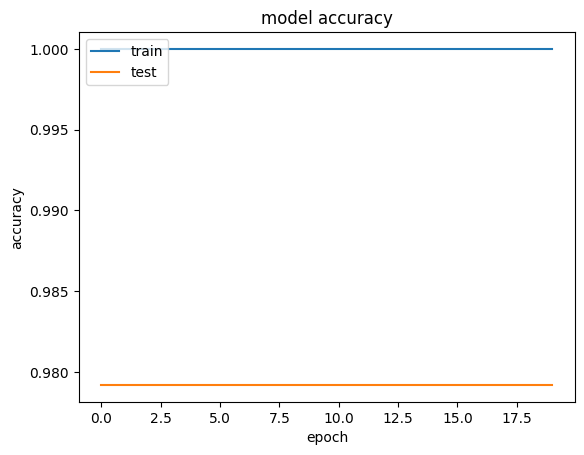

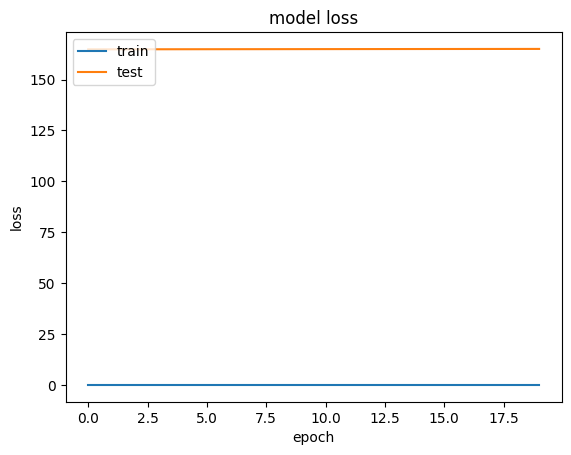

In [17]:
# 3. Evaluation at server

memoryTraining=process.memory_percent()
timeTraining=time.time() - start_time
print("---Memory---",memoryTraining)
print("--- %s seconds (TRAINING)---" % (timeTraining))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

history = deepModel.fit(xServer, yServer, epochs=epochs, 
                        validation_data = (xTest,yTest), verbose=0)
                        # callbacks=[early_stopping])

learningAccs = history.history['val_accuracy']
learningLoss=history.history['val_loss']

def Analyze_training(h):
# summarize history for accuracy
# history.history.keys() -> dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
   plt.plot(h.history['accuracy'])
   plt.plot(h.history['val_accuracy'])
   plt.title('model accuracy')
   plt.ylabel('accuracy')
   plt.xlabel('epoch')
   plt.legend(['train', 'test'], loc='upper left')
   plt.show()
# summarize history for loss
   plt.plot(h.history['loss'])
   plt.plot(h.history['val_loss'])
   plt.title('model loss')
   plt.ylabel('loss')
   plt.xlabel('epoch')
   plt.legend(['train', 'test'], loc='upper left')
   plt.show()
   return

Analyze_training(history)

In [18]:
# evaluation results
# resultSaveLocation=root_path+'Results/'+algoName+'_Users_vs_TR_vs_Iterations_vs_AccLossMemTime'+'.csv'
dfSave=pd.DataFrame(columns=['Clients', 'Iterations to converge', 'Accuracy', 'Loss', 'Memory', 'Time'])
dfSaveIndex=0
saveList = [numOfClients, len(learningLoss), learningAccs[len(learningAccs)-1], learningLoss[len(learningLoss)-1], memoryTraining, timeTraining]
dfSave.loc[dfSaveIndex] = saveList

yPredict = deepModel.predict(xTest)
acc, prec, recall, f1Score= predictTestData(yPredict, yTest)

print("Number of users:", numOfClients)
deepModel.save(modelLocation)


print("Iterations:", numOfIterations)
print("Memory:", memoryTraining)
print("Time:", timeTraining)
print(dfSave)

df_performance_timeRounds = pd.DataFrame(
    {'Accuracy': accList,
     'Precision': precList,
     'Recall': recallList,
     'F1-Score': f1List 
    })

yPredict 10000
Accuracy  : 0.9792
Precision : 0.9792339959398417
Recall : 0.9792
f1Score : 0.9792022273718336
[[ 966    0    2    2    2    1    1    3    2    1]
 [   0 1125    2    0    0    1    2    1    4    0]
 [   1    0 1014    7    1    1    0    3    5    0]
 [   0    0    6  992    0    2    0    3    6    1]
 [   1    3    3    0  960    1    5    2    0    7]
 [   2    0    0   14    1  869    2    1    2    1]
 [   4    2    0    1    6    3  940    2    0    0]
 [   0    3   10    1    3    0    0 1000    7    4]
 [   3    2    2    7    3    5    2    4  943    3]
 [   2    4    0    4    9    2    0    3    2  983]]
Number of users: 10
Iterations: 50
Memory: 5.626645794876741
Time: 6500.151785135269
   Clients  Iterations to converge  Accuracy        Loss    Memory  \
0     10.0                    20.0    0.9792  165.070465  5.626646   

          Time  
0  6500.151785  
